In [1]:
import ee 
import geemap 
import rasterio
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
#ee.Authenticate()
ee.Initialize()

In [3]:
b = {'type': 'Polygon',
     'coordinates':  
    [[[2.3285228024062548, 6.525337179867414],
[2.553375186295776, 6.525337179867414],
[2.553375186295776, 6.372296290309101],
[2.3285228024062548, 6.372296290309101],
[2.3285228024062548, 6.525337179867414]]], 
   }

#projected --> EPSG:32631
b2 = {'type': 'Polygon',
     'coordinates':  
    [[[425760.53673725965, 721298.9411820257],
[2450602.64087725966, 721298.9411820257],
[2450602.64087725966, 704407.1114020257],
[425760.53673725965, 704407.1114020257],
[425760.53673725965, 721298.9411820257]]], 
   }

In [4]:
def otsuSearch(IMG):
    scale=10
    def otsu(t, r):
    #https://ieeexplore.ieee.org/document/4310076
        t = ee.Number(t)
        IMGBname = IMG.bandNames().get(0)
        
        IMGSum1 = (ee.Number(IMG.lt(t)
                             .reduceRegion(ee.Reducer.sum(), geometry=b,  scale=scale ).get(IMGBname)))
        npixel = (ee.Number(IMG
                            .reduceRegion(ee.Reducer.count(),  geometry=b , 
                                          scale=scale ).get(IMGBname)))

        w0 = ee.Number(IMGSum1.divide(npixel))
        mu0 = (ee.Number(IMG
                         .updateMask(IMG.lt(t))
                         .reduceRegion(ee.Reducer.mean(), geometry=b , scale=scale).get(IMGBname)))
        
        w1 = ee.Number(1).subtract(w0)

        mu1 = ee.Number(IMG.updateMask(IMG.gt(t))
                        .reduceRegion(ee.Reducer.mean(), geometry=b, scale=scale ).get(IMGBname))
        return  ee.List(r).add(ee.Number(w0.multiply(w1).multiply((mu1.subtract(mu0)).pow(2))))
    
    minPixel = (ee.Number(IMG
                          .reduceRegion(ee.Reducer.min(), geometry=b,  
                                        scale=scale).get(IMG.bandNames().get(0))))
    maxPixel = (ee.Number(IMG
                          .reduceRegion(ee.Reducer.max(), geometry=b,  scale=scale ).get(IMG.bandNames().get(0))))
    
    ts = ee.List.sequence(start=minPixel.add(1), end=maxPixel.subtract(1), count=100)
    res = ee.List([])

    ostuvals = ee.List(ts.iterate(otsu, res))
    t_best = ts.get(ee.Array(ostuvals).argmax().get(0))
    
    return ee.Image(IMG.lt(ee.Number(t_best)).int8())

powerToDb = lambda img: ee.Image(10).multiply(img.log10());
dbToPower = lambda img: ee.Image(10).pow(img.divide(10));

def radioTerrainCorrect(img):
#Implementation by Andreas Vollrath (ESA), inspired by Johannes Reiche (Wageningen)
    imgGeom = img.geometry()
    srtm = ee.Image('USGS/SRTMGL1_003').clip(imgGeom)
    sigma0Pow = ee.Image.constant(10).pow(img.divide(10.0))
    theta_i = img.select('angle')
    phi_i = (ee.Terrain.aspect(theta_i).reduceRegion(ee.Reducer.mean(), theta_i.get('system:footprint'), 1000)
    .get('aspect'))
    alpha_s = ee.Terrain.slope(srtm).select('slope')
    phi_s = ee.Terrain.aspect(srtm).select('aspect')
    phi_r = ee.Image.constant(phi_i).subtract(phi_s)
    
    phi_rRad = phi_r.multiply(np.pi / 180)
    alpha_sRad = alpha_s.multiply(np.pi / 180)
    theta_iRad = theta_i.multiply(np.pi / 180)
    ninetyRad = ee.Image.constant(90).multiply(np.pi / 180)
    
    alpha_r = (alpha_sRad.tan().multiply(phi_rRad.cos())).atan()
    alpha_az = (alpha_sRad.tan().multiply(phi_rRad.sin())).atan()
    theta_lia = (alpha_az.cos().multiply((theta_iRad.subtract(alpha_r)).cos())).acos()
    theta_liaDeg = theta_lia.multiply(180 / np.pi)
    gamma0 = sigma0Pow.divide(theta_iRad.cos())
    gamma0dB = ee.Image.constant(10).multiply(gamma0.log10())
    ratio_1 = gamma0dB.select('VV').subtract(gamma0dB.select('VH'))
    
    nominator = (ninetyRad.subtract(theta_iRad).add(alpha_r)).tan()
    denominator = (ninetyRad.subtract(theta_iRad)).tan()
    volModel = (nominator.divide(denominator)).abs()
    
    gamma0_Volume = gamma0.divide(volModel)
    gamma0_VolumeDB = ee.Image.constant(10).multiply(gamma0_Volume.log10())
    alpha_rDeg = alpha_r.multiply(180 / np.pi)
    layover = alpha_rDeg.lt(theta_i)
    
    shadow = theta_liaDeg.lt(85)
    ratio = gamma0_VolumeDB.select('VV').subtract(gamma0_VolumeDB.select('VH'))
    
    output = (gamma0_VolumeDB.addBands(ratio).addBands(alpha_r).addBands(phi_s).addBands(theta_iRad)
    .addBands(layover).addBands(shadow).addBands(gamma0dB).addBands(ratio_1))
    
    return img.addBands(ee.Image(output.select(['VV', 'VH'], ['VV', 'VH'])), None, True)


def _LeeFilter(img):
    #adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
    img_power = dbToPower(img)

    bname = img_power.bandNames()
    weights3 = ee.List.repeat(ee.List.repeat(1,3),3);
    kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False);
    img_mean = img_power.reduceNeighborhood(ee.Reducer.mean(), kernel3).clip(img.geometry())
    img_sqr_mean = img_power.pow(2).reduceNeighborhood(ee.Reducer.mean(), kernel3)
    img_variance = img_sqr_mean.subtract(img_mean.pow(2))

    Ovariance = (ee.Dictionary(img_power
                           .reduceRegion(ee.Reducer.variance(), 
                                         geometry=img.geometry(), 
                                         scale = 10, bestEffort = True))).toImage()
    K_img = img_variance.divide(img_variance.add(Ovariance))
    centeredImg = img_power.subtract(img_mean)
    output = ee.Image(img_mean.add(K_img.multiply(centeredImg))
            
                     )
    
    return (powerToDb(output).clip(img.geometry())
            .rename(bname).copyProperties(img,None,None)
            .set('system:time_start',img.get('system:time_start')))
               

In [5]:
Sentinel_VH = (ee.ImageCollection('COPERNICUS/S1_GRD')
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
.filter(ee.Filter.eq('instrumentMode', 'IW'))
.filter(ee.Filter.date('2015-06-01', '2023-04-12'))
.select('VH')
.filterBounds(b)
#.map(lambda img: _LeeFilter(img))
)


In [7]:
Map = geemap.Map()
Map.addLayer(Sentinel_VH.first(), {'min':-20, 'max':20})
Map.add_geojson(b)
#Map

In [6]:
def _get_dateName(systemIndex):
    d = systemIndex.split('_')[4]
    y = d[:4]
    m = d[4:6]
    return f"{y}-{m}"

firstdate =_get_dateName(
        Sentinel_VH.sort("system:time_start", True).first().get("system:index").getInfo()
    )
lastdate =  _get_dateName(
        Sentinel_VH.sort("system:time_start", False).first().get("system:index").getInfo()
    )

Year_month = ee.List((pd.date_range(firstdate, lastdate, freq='MS')
 .to_frame(name='date')
 .assign(year= lambda x:x.date.dt.year  , month= lambda x: x.date.dt.month))[['year', 'month']].values.tolist())


In [7]:
def monthly_median_func(m):
    
    return (
        ee.Image(Sentinel_VH
                 .filter(ee.Filter.calendarRange(ee.List(m).get(0) ,ee.List(m).get(0), 'year'))
                 .filter(ee.Filter.calendarRange(ee.List(m).get(1) ,ee.List(m).get(1), 'month'))
                 .median()
                 .set('month', ee.List(m).get(1))
                 .set('year', ee.List(m).get(0)))
           ).clip(Sentinel_VH.first().geometry()).rename('VH')

Monthly_VH = (ee.ImageCollection
              .fromImages(Year_month.map(monthly_median_func))
              .map(lambda im: im.clip(b)#.reproject("EPSG:32631")
                  )
             )

In [8]:
Map = geemap.Map(center = b['coordinates'][0][0], zoom=7)


Map.add_basemap()
Map.addLayer(Monthly_VH.first(), {'min':-20, 'max':20})

Map


Map(center=[2.3285228024062548, 6.525337179867414], controls=(WidgetControl(options=['position', 'transparent_…

In [9]:
ImgsList = Monthly_VH.toList(Monthly_VH.size())

In [10]:
n = ImgsList.size().getInfo()
for i in range(0, n):
    break
    Img = ee.Image(_LeeFilter(ee.Image(ImgsList.get(i))))
    info = Img.getInfo()
    name = f"Month{info['properties']['month']}_Year{info['properties']['year']}_water.tif"


    waterImg = otsuSearch(Img).clip(b).reproject("EPSG:32631", scale=10)
    savePath = rf"{name}"
    geemap.ee_export_image(waterImg, savePath,format="GEO_TIFF")


In [11]:
def read_raster(p):
    with rasterio.open(p) as src:
        band = src.read().squeeze()
    return band 

In [12]:
def get_all_water_bands():
    files = os.listdir()
    all_bands = []
    
    Year_month = (pd.date_range(firstdate, lastdate, freq='MS')
     .to_frame(name='date')
     .assign(year= lambda x:x.date.dt.year  , month= lambda x: x.date.dt.month))

    
    name = "Month{m}_Year{y}_water.tif"
    date = []
    for ix, row in Year_month.iterrows():
        
        nfile = f"Month{row.month}_Year{row.year}_water.tif" 
        
        #Check path 
        pfile = rf"{nfile}"
        if os.path.exists(pfile):
            b = read_raster(pfile).astype('float')
            b[np.abs(b) > 1] = np.nan
            all_bands.append(b)
            date.append(f"{row.year}-{row.month}")
        
    return date, np.stack(all_bands, axis=-1)

In [13]:
dates, Wbands = get_all_water_bands()

In [14]:
prob = np.sum(Wbands, axis=(-1, ), )/Wbands.shape[-1]

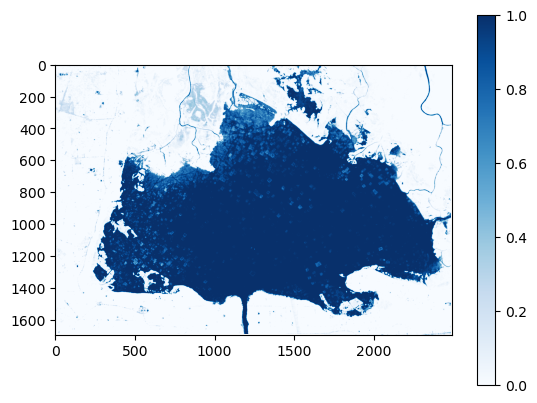

In [16]:
plt.imshow(prob, cmap=plt.cm.Blues)
plt.colorbar()

In [ ]:
p = r"Month7_Year2021_water.tif"
with rasterio.open(p) as src:
    #Take one of the saved waterImg to copy the profile to save the probability image
    profile = src.profile
    profile.update({"dtype":np.float32})
    with rasterio.open(r"Prob_VH.tif", "w", **profile) as dst:
        dst.write(prob, 1)

In [18]:
area_time_series = np.nansum(Wbands, axis=(0, 1)) * ((10 * 10) /  1e+6)

areakm2 = (pd.to_datetime(dates)
     .to_frame(name='date')
     .assign(areakm2 = area_time_series)

)

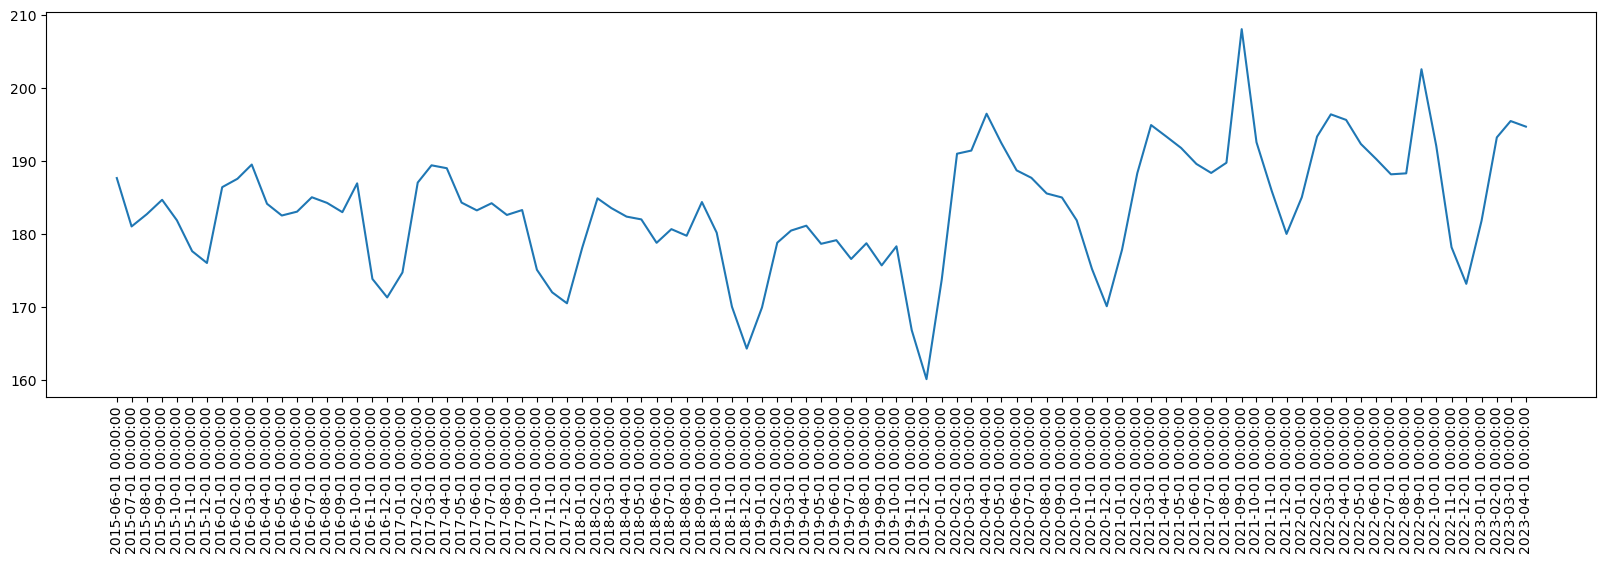

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(areakm2.date, areakm2.areakm2)
ax.set_xticks(areakm2.date, areakm2.date, rotation = 90);

In [20]:
from pymannkendall import hamed_rao_modification_test
print(hamed_rao_modification_test(areakm2.areakm2, lag=3))

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.0767759525708922, z=1.7697070637176398, Tau=0.20627099664053752, s=921.0, var_s=270254.47004108375, slope=0.09025416666666668, intercept=179.36145416666668)


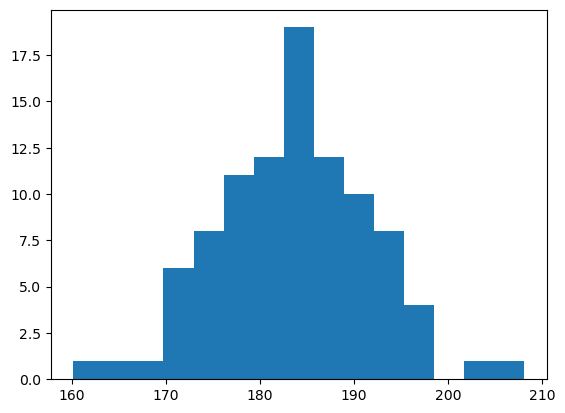

In [21]:
plt.hist(areakm2.areakm2, bins=15);

In [52]:
def maskS2clouds(image):
    qa = image.select('QA60');

  #Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

  #Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0));
    return image.updateMask(mask).divide(10000);



Sentinel2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate("2022-12-25", "2022-12-27")
    .filterBounds(b)

    .map(maskS2clouds)
    .map(lambda img: img.clip(b)).first()
)

S2vis = {
  "min": 0.0,
  "max": 0.3,
  "bands": ['B4', 'B3', 'B2']
}

In [54]:
Map = geemap.Map(center = b['coordinates'][0][0], zoom=7)
#Map.center(b['coordinates'][0][0])

Map.addLayer(Sentinel2, S2vis)
Map.add_geojson(b)
Map

Map(center=[2.3285228024062548, 6.525337179867414], controls=(WidgetControl(options=['position', 'transparent_…